In this Notebook, we will train a Reinforcement Learing Agent to maximize the cumulative return by having a portfolio that comprises of the individual stocks from the S&P100. The agent will perform the portfolio allocation and maximize its cumulative return over the training horizon. We will show at the end the out-of-sample performance. 

Several important criterias as follows:
1. This is a single-period RL system. We intend to extend this to a multi-period approach by the next submission. 
2. The training dataset is between 01-01-1990 and 01-08-2017 whereas the testing dataset is between 01-09-2017 and 01-07-2024.
3. We will use a monthly frequency instead of daily.
4. The following features are used in this notebook: closing price, high price, low price
5. In the RL setting:
    - The state is a 3d tensor with shape (f,n,m). F: number of features, n: number of input periods, m: number of assets
    - The portfolio reward is the logarithmic return of the portfolio
    - The model used is called Ensemble of Identical Independent Evaluators: https://arxiv.org/abs/1706.10059
    - The agent makes an action of selecting weights/allocations for these stocks
6. For Benchmark comparison in the other Notebook, we have an Multi-Period Markowitz's Mean Variance and the S&P100 index itself.

In [76]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set()

In [3]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [6]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class GroupByScaler(BaseEstimator, TransformerMixin):
    """Sklearn-like scaler that scales considering groups of data.

    In the financial setting, this scale can be used to normalize a DataFrame
    with time series of multiple tickers. The scaler will fit and transform
    data for each ticker independently.
    """

    def __init__(self, by, scaler=MaxAbsScaler, columns=None, scaler_kwargs=None):
        """Initializes GoupBy scaler.

        Args:
            by: Name of column that will be used to group.
            scaler: Scikit-learn scaler class to be used.
            columns: List of columns that will be scaled.
            scaler_kwargs: Keyword arguments for chosen scaler.
        """
        self.scalers = {}  # dictionary with scalers
        self.by = by
        self.scaler = scaler
        self.columns = columns
        self.scaler_kwargs = {} if scaler_kwargs is None else scaler_kwargs

    def fit(self, X, y=None):
        """Fits the scaler to input data.

        Args:
            X: DataFrame to fit.
            y: Not used.

        Returns:
            Fitted GroupBy scaler.
        """
        # if columns aren't specified, considered all numeric columns
        if self.columns is None:
            self.columns = X.select_dtypes(exclude=["object"]).columns
        # fit one scaler for each group
        for value in X[self.by].unique():
            X_group = X.loc[X[self.by] == value, self.columns]
            self.scalers[value] = self.scaler(**self.scaler_kwargs).fit(X_group)
        return self

    def transform(self, X, y=None):
        """Transforms unscaled data.

        Args:
            X: DataFrame to transform.
            y: Not used.

        Returns:
            Transformed DataFrame.
        """
        # apply scaler for each group
        X = X.copy()
        for value in X[self.by].unique():
            select_mask = X[self.by] == value
            X.loc[select_mask, self.columns] = self.scalers[value].transform(
                X.loc[select_mask, self.columns]
            )
        return X


Using the 101 Stocks from the S&P100

In [8]:
sp_100 = [
    'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT', 'AMZN',
    'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'BRK-B', 'C',
    'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS',
    'CVX', 'DE', 'DHR', 'DIS', 'DUK', 'EMR', 'F', 'FDX', 'GD',
    'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC',
    'INTU', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA',
    'MCD', 'MDLZ', 'MDT', 'MET', 'META', 'MMM', 'MO', 'MRK', 'MS', 'MSFT',
    'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM',
    'QCOM', 'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS',
    'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT',
    'XOM', 'DOW', 'PYPL', 'KHC'
]
len(sp_100)

101

Data Collection and Data Preprocessing

In [9]:
portfolio_raw_df = yf.download(tickers=sp_100, start="1990-01-01", end="2024-08-01", interval="1mo")
portfolio_raw_df.fillna(method="bfill", inplace=True)
portfolio_raw_df = portfolio_raw_df.stack(level=1).rename_axis(["Date", "Ticker"]).reset_index(level=1)

portfolio_raw_df = portfolio_raw_df.drop("Adj Close", axis=1)
portfolio_raw_df.columns.name = None
portfolio_raw_df = portfolio_raw_df.reset_index()
portfolio_raw_df.Date = portfolio_raw_df.Date.astype(str)
portfolio_raw_df.columns = ["date", "tic", "close", "high", "low", "open", "volume"]

[*********************100%%**********************]  101 of 101 completed
/var/folders/02/rmgfx9wj0s99nn4tzfthtrnc0000gn/T/ipykernel_52250/3811137442.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  portfolio_raw_df.fillna(method="bfill", inplace=True)
/var/folders/02/rmgfx9wj0s99nn4tzfthtrnc0000gn/T/ipykernel_52250/3811137442.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  portfolio_raw_df = portfolio_raw_df.stack(level=1).rename_axis(["Date", "Ticker"]).reset_index(level=1)


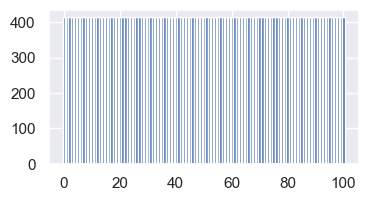

In [83]:
# Ensuring the data is complete and there is no NaNs. the bar plots show they all have the same count
plt.figure(figsize=(4,2))
plt.bar(np.arange(0, len(sp_100), 1), portfolio_raw_df.groupby("tic").count().mean(1))
plt.show()

In [11]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low", "open"]]
df_portfolio_train, df_portfolio_test = train_test_split(df_portfolio, test_size=0.2, shuffle=False, random_state=43)
len(df_portfolio_train), len(df_portfolio_test)

Setting Hyperparameters

In [20]:
T = 24 # last 2 years of data
num_features = 3

Initializing the Portfolio Optimization Environment

In [21]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=T,
        features=["close", "high", "low"],
        normalize_df=None
    )

In [22]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": T,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

Model Training with 50 episodes

In [35]:
DRLAgent.train_model(model, episodes=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 461065664.0
Final accumulative portfolio value: 4610.65664
Maximum DrawDown: -0.4357276597811147
Sharpe ratio: 5.592420520227282


  2%|▏         | 1/50 [00:08<06:52,  8.42s/it]

Initial portfolio value:100000
Final portfolio value: 463191744.0
Final accumulative portfolio value: 4631.91744
Maximum DrawDown: -0.4354843742216671
Sharpe ratio: 5.598459149272775


  4%|▍         | 2/50 [00:16<06:45,  8.45s/it]

Initial portfolio value:100000
Final portfolio value: 465263872.0
Final accumulative portfolio value: 4652.63872
Maximum DrawDown: -0.4349658029785002
Sharpe ratio: 5.6073241109652


  6%|▌         | 3/50 [00:25<06:33,  8.38s/it]

Initial portfolio value:100000
Final portfolio value: 467381312.0
Final accumulative portfolio value: 4673.81312
Maximum DrawDown: -0.4343618640326845
Sharpe ratio: 5.61669676654591


  8%|▊         | 4/50 [00:33<06:21,  8.30s/it]

Initial portfolio value:100000
Final portfolio value: 469593024.0
Final accumulative portfolio value: 4695.93024
Maximum DrawDown: -0.43367356512244837
Sharpe ratio: 5.627134741899222


 10%|█         | 5/50 [00:41<06:12,  8.27s/it]

Initial portfolio value:100000
Final portfolio value: 471658400.0
Final accumulative portfolio value: 4716.584
Maximum DrawDown: -0.43294503169280374
Sharpe ratio: 5.637226662783759


 12%|█▏        | 6/50 [00:49<06:02,  8.23s/it]

Initial portfolio value:100000
Final portfolio value: 473988512.0
Final accumulative portfolio value: 4739.88512
Maximum DrawDown: -0.43224164981742363
Sharpe ratio: 5.647704586714541


 14%|█▍        | 7/50 [00:57<05:53,  8.22s/it]

Initial portfolio value:100000
Final portfolio value: 476165056.0
Final accumulative portfolio value: 4761.65056
Maximum DrawDown: -0.43138342395557583
Sharpe ratio: 5.660039531231596


 16%|█▌        | 8/50 [01:06<05:43,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 478296992.0
Final accumulative portfolio value: 4782.96992
Maximum DrawDown: -0.43062328666282645
Sharpe ratio: 5.67056071710397


 18%|█▊        | 9/50 [01:14<05:35,  8.17s/it]

Initial portfolio value:100000
Final portfolio value: 480574016.0
Final accumulative portfolio value: 4805.74016
Maximum DrawDown: -0.42990621554024355
Sharpe ratio: 5.681311963928883


 20%|██        | 10/50 [01:22<05:26,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 482863840.0
Final accumulative portfolio value: 4828.6384
Maximum DrawDown: -0.4291765906310864
Sharpe ratio: 5.692686155228785


 22%|██▏       | 11/50 [01:30<05:17,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 485232320.0
Final accumulative portfolio value: 4852.3232
Maximum DrawDown: -0.42856621343114976
Sharpe ratio: 5.702231265835215


 24%|██▍       | 12/50 [01:38<05:11,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 486563072.0
Final accumulative portfolio value: 4865.63072
Maximum DrawDown: -0.42823424218648576
Sharpe ratio: 5.706122038064977


 26%|██▌       | 13/50 [01:46<05:01,  8.16s/it]

Initial portfolio value:100000
Final portfolio value: 490034784.0
Final accumulative portfolio value: 4900.34784
Maximum DrawDown: -0.42768241261412787
Sharpe ratio: 5.718492918356009


 28%|██▊       | 14/50 [01:54<04:53,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 492191104.0
Final accumulative portfolio value: 4921.91104
Maximum DrawDown: -0.42707398332266167
Sharpe ratio: 5.729455837850827


 30%|███       | 15/50 [02:03<04:46,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 494378880.0
Final accumulative portfolio value: 4943.7888
Maximum DrawDown: -0.42672589592378096
Sharpe ratio: 5.73694434044812


 32%|███▏      | 16/50 [02:11<04:40,  8.25s/it]

Initial portfolio value:100000
Final portfolio value: 496681568.0
Final accumulative portfolio value: 4966.81568
Maximum DrawDown: -0.42664515457075636
Sharpe ratio: 5.742110548478257


 34%|███▍      | 17/50 [02:19<04:33,  8.29s/it]

Initial portfolio value:100000
Final portfolio value: 499106464.0
Final accumulative portfolio value: 4991.06464
Maximum DrawDown: -0.42675913317516
Sharpe ratio: 5.745607056148127


 36%|███▌      | 18/50 [02:28<04:24,  8.26s/it]

Initial portfolio value:100000
Final portfolio value: 501669216.0
Final accumulative portfolio value: 5016.69216
Maximum DrawDown: -0.42700724242394617
Sharpe ratio: 5.7479839082114


 38%|███▊      | 19/50 [02:36<04:15,  8.24s/it]

Initial portfolio value:100000
Final portfolio value: 504377216.0
Final accumulative portfolio value: 5043.77216
Maximum DrawDown: -0.4273396400357411
Sharpe ratio: 5.74971093898206


 40%|████      | 20/50 [02:44<04:06,  8.23s/it]

Initial portfolio value:100000
Final portfolio value: 507232640.0
Final accumulative portfolio value: 5072.3264
Maximum DrawDown: -0.4277128019357851
Sharpe ratio: 5.751168909708884


 42%|████▏     | 21/50 [02:52<03:59,  8.25s/it]

Initial portfolio value:100000
Final portfolio value: 510241536.0
Final accumulative portfolio value: 5102.41536
Maximum DrawDown: -0.4280952988076243
Sharpe ratio: 5.7526486640598815


 44%|████▍     | 22/50 [03:01<03:50,  8.24s/it]

Initial portfolio value:100000
Final portfolio value: 513409760.0
Final accumulative portfolio value: 5134.0976
Maximum DrawDown: -0.4284625836883338
Sharpe ratio: 5.7543611824281635


 46%|████▌     | 23/50 [03:09<03:42,  8.24s/it]

Initial portfolio value:100000
Final portfolio value: 516748352.0
Final accumulative portfolio value: 5167.48352
Maximum DrawDown: -0.4288018503609786
Sharpe ratio: 5.756432357272388


 48%|████▊     | 24/50 [03:17<03:34,  8.24s/it]

Initial portfolio value:100000
Final portfolio value: 520268608.0
Final accumulative portfolio value: 5202.68608
Maximum DrawDown: -0.42910577985217313
Sharpe ratio: 5.758927198375821


 50%|█████     | 25/50 [03:25<03:26,  8.27s/it]

Initial portfolio value:100000
Final portfolio value: 523982912.0
Final accumulative portfolio value: 5239.82912
Maximum DrawDown: -0.4293750529888153
Sharpe ratio: 5.761850252592032


 52%|█████▏    | 26/50 [03:34<03:19,  8.30s/it]

Initial portfolio value:100000
Final portfolio value: 527908000.0
Final accumulative portfolio value: 5279.08
Maximum DrawDown: -0.42961015781985923
Sharpe ratio: 5.765174752900646


 54%|█████▍    | 27/50 [03:42<03:10,  8.28s/it]

Initial portfolio value:100000
Final portfolio value: 532069024.0
Final accumulative portfolio value: 5320.69024
Maximum DrawDown: -0.4298186199674008
Sharpe ratio: 5.768849419016658


 56%|█████▌    | 28/50 [03:50<03:01,  8.23s/it]

Initial portfolio value:100000
Final portfolio value: 536495616.0
Final accumulative portfolio value: 5364.95616
Maximum DrawDown: -0.4300059537076739
Sharpe ratio: 5.772813123619017


 58%|█████▊    | 29/50 [03:58<02:52,  8.22s/it]

Initial portfolio value:100000
Final portfolio value: 541223936.0
Final accumulative portfolio value: 5412.23936
Maximum DrawDown: -0.43017835706014784
Sharpe ratio: 5.777002433019301


 60%|██████    | 30/50 [04:06<02:43,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 546301312.0
Final accumulative portfolio value: 5463.01312
Maximum DrawDown: -0.43034187425317616
Sharpe ratio: 5.78137051189022


 62%|██████▏   | 31/50 [04:15<02:35,  8.17s/it]

Initial portfolio value:100000
Final portfolio value: 551799488.0
Final accumulative portfolio value: 5517.99488
Maximum DrawDown: -0.4304980262671171
Sharpe ratio: 5.785906677563075


 64%|██████▍   | 32/50 [04:23<02:27,  8.21s/it]

Initial portfolio value:100000
Final portfolio value: 557811648.0
Final accumulative portfolio value: 5578.11648
Maximum DrawDown: -0.4306470432150097
Sharpe ratio: 5.790626824663796


 66%|██████▌   | 33/50 [04:31<02:19,  8.20s/it]

Initial portfolio value:100000
Final portfolio value: 564469440.0
Final accumulative portfolio value: 5644.6944
Maximum DrawDown: -0.4307839360575981
Sharpe ratio: 5.795601641752025


 68%|██████▊   | 34/50 [04:39<02:10,  8.18s/it]

Initial portfolio value:100000
Final portfolio value: 571984128.0
Final accumulative portfolio value: 5719.84128
Maximum DrawDown: -0.4309011355662048
Sharpe ratio: 5.800988209062925


 70%|███████   | 35/50 [04:47<02:02,  8.17s/it]

Initial portfolio value:100000
Final portfolio value: 580649984.0
Final accumulative portfolio value: 5806.49984
Maximum DrawDown: -0.43098543898715624
Sharpe ratio: 5.807021803223379


 72%|███████▏  | 36/50 [04:55<01:54,  8.16s/it]

Initial portfolio value:100000
Final portfolio value: 590737664.0
Final accumulative portfolio value: 5907.37664
Maximum DrawDown: -0.4310058428241358
Sharpe ratio: 5.813949519598389


 74%|███████▍  | 37/50 [05:04<01:46,  8.16s/it]

Initial portfolio value:100000
Final portfolio value: 603122368.0
Final accumulative portfolio value: 6031.22368
Maximum DrawDown: -0.4309186461166259
Sharpe ratio: 5.822453417345196


 76%|███████▌  | 38/50 [05:12<01:37,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 619407104.0
Final accumulative portfolio value: 6194.07104
Maximum DrawDown: -0.43067635502817436
Sharpe ratio: 5.833553960170864


 78%|███████▊  | 39/50 [05:20<01:29,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 642201856.0
Final accumulative portfolio value: 6422.01856
Maximum DrawDown: -0.4302431408853815
Sharpe ratio: 5.84814856434016


 80%|████████  | 40/50 [05:28<01:21,  8.14s/it]

Initial portfolio value:100000
Final portfolio value: 678588672.0
Final accumulative portfolio value: 6785.88672
Maximum DrawDown: -0.42955436063091357
Sharpe ratio: 5.868081902402149


 82%|████████▏ | 41/50 [05:36<01:13,  8.14s/it]

Initial portfolio value:100000
Final portfolio value: 736208128.0
Final accumulative portfolio value: 7362.08128
Maximum DrawDown: -0.42844188423354646
Sharpe ratio: 5.885386959669689


 84%|████████▍ | 42/50 [05:44<01:05,  8.15s/it]

Initial portfolio value:100000
Final portfolio value: 845525696.0
Final accumulative portfolio value: 8455.25696
Maximum DrawDown: -0.42707407540130027
Sharpe ratio: 5.881992007979575


 86%|████████▌ | 43/50 [05:52<00:57,  8.14s/it]

Initial portfolio value:100000
Final portfolio value: 973870400.0
Final accumulative portfolio value: 9738.704
Maximum DrawDown: -0.4261050387409494
Sharpe ratio: 5.732693268049549


 88%|████████▊ | 44/50 [06:01<00:48,  8.16s/it]

Initial portfolio value:100000
Final portfolio value: 1110663424.0
Final accumulative portfolio value: 11106.63424
Maximum DrawDown: -0.42648056084016084
Sharpe ratio: 5.810094119713537


 90%|█████████ | 45/50 [06:09<00:40,  8.17s/it]

Initial portfolio value:100000
Final portfolio value: 1795711488.0
Final accumulative portfolio value: 17957.11488
Maximum DrawDown: -0.43069712441906294
Sharpe ratio: 5.847614125104445


 92%|█████████▏| 46/50 [06:17<00:32,  8.22s/it]

Initial portfolio value:100000
Final portfolio value: 1984326784.0
Final accumulative portfolio value: 19843.26784
Maximum DrawDown: -0.4695539344463795
Sharpe ratio: 5.490320940395216


 94%|█████████▍| 47/50 [06:25<00:24,  8.21s/it]

Initial portfolio value:100000
Final portfolio value: 2164970496.0
Final accumulative portfolio value: 21649.70496
Maximum DrawDown: -0.4951638505773944
Sharpe ratio: 5.507697165188352


 96%|█████████▌| 48/50 [06:34<00:16,  8.19s/it]

Initial portfolio value:100000
Final portfolio value: 2198236672.0
Final accumulative portfolio value: 21982.36672
Maximum DrawDown: -0.503538284383645
Sharpe ratio: 5.7092774989934805


 98%|█████████▊| 49/50 [06:42<00:08,  8.18s/it]

Initial portfolio value:100000
Final portfolio value: 2762716672.0
Final accumulative portfolio value: 27627.16672
Maximum DrawDown: -0.5073644171348802
Sharpe ratio: 5.409682354051288


100%|██████████| 50/50 [06:50<00:00,  8.21s/it]


In [36]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

Setting the test environment

In [37]:
environment_test = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=T,
        features=["close", "high", "low"],
        normalize_df=None
)

In [38]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "test": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(k_size=3, 
              time_window=T,
              device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

DRLAgent.DRL_validation(model, environment_test, policy=policy)
EIIE_results["test"]["value"] = environment_test._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 231892.28125
Final accumulative portfolio value: 2.3189228125
Maximum DrawDown: -0.5084143035342543
Sharpe ratio: 2.761236660916153


In [99]:
out_of_sample_df = pd.DataFrame(index=pd.to_datetime(df_portfolio_test.date.unique()[T-1:]),
                                data=EIIE_results["test"]["value"], columns=["RL"])
out_of_sample_metrics = out_of_sample_df.pct_change().fillna(0)
out_of_sample_df = (out_of_sample_df/out_of_sample_df.iloc[0]) - 1

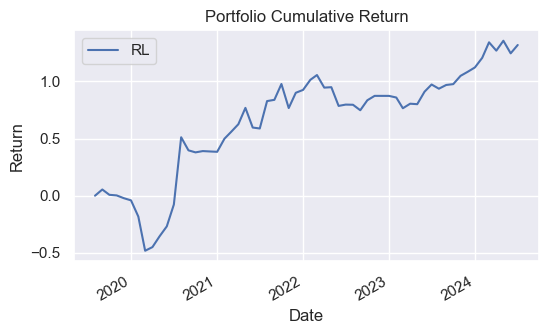

In [74]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(out_of_sample_df.index, out_of_sample_df, label="RL")
ax.set_ylabel('Return')
ax.set_xlabel("Date")
ax.legend()
plt.title("Portfolio Cumulative Return")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

Preparing Statistics for portfolio performance

In [110]:
import quantstats as qs

In [129]:
rl_sharpe_ratio = qs.stats.sharpe(out_of_sample_metrics, periods=12).item()
rl_mdd = qs.stats.max_drawdown(out_of_sample_metrics).item()
rl_fapv = out_of_sample_df.iloc[-1].item()
print(f"RL Sharpe Ratio: {rl_sharpe_ratio}")
print(f"RL Max Drawdown: {rl_mdd}")
print(f"RL final Accumulated Portfolio Value (fAPV): {rl_fapv}x")

RL Sharpe Ratio: 0.602551103321849
RL Max Drawdown: -0.5084143035342541
RL final Accumulated Portfolio Value (fAPV): 1.3189228124999999x


Findings

Our finding from the Reinforcement Learning model shows that the agent was able to make more money than the benchmark but it has a way lower Sharpe ratio. This can be mitigated by better training and through the addition of more features such as technical analysis, longer lookback period and other forms of alternative data such as sentiment. We also have to train these models multiple times and average the results to have a more consistent result on model performance. Nonetheless, here we want to show that a simple RL agent can beat the benchmarks and it can be further fine-tuned and improved for better performance. In our older submission, we showed that we were able to have Deep Learning architectures that can learn better such as Transformers. In this Example, the Agent has a Policy Algorithm of Ensemble of Identical Independent Evaluators (EIIE), which is a series of convolutions trained on understanding the short-term and long term trends of these stocks. We will use other Policy Gradients such as Transformer model as our previous submission and test its predictive capability in assigning portfolio weights for optimal allocation. 